# ISIC 2017 Lesion Classification

Every notebook starts with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.

In [5]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

Import libraries

In [6]:
from fastai.vision import *
import matplotlib.pyplot as plt
from sklearn.metrics import auc, roc_curve

Initialize path to dataset

In [7]:
data_path = Path('modified_data')
data_path.ls()

[PosixPath('modified_data/models'),
 PosixPath('modified_data/valid'),
 PosixPath('modified_data/test'),
 PosixPath('modified_data/export6.pkl'),
 PosixPath('modified_data/train')]

Subclass ImageList to implement a custom function to obtain labels

In [8]:
class MyImageList(ImageList):
    def get_label_from_directory_and_map(self, lesion_to_label_map, **kwargs):
        get_labels = np.vectorize(lambda image_file_path: lesion_to_label_map[str(image_file_path).split('/')[-2]])
        labels = get_labels(self.items)
        y = CategoryList(labels, path=self.path)
        res = self._label_list(x=self, y=y)
        return res

Prepare dataset for training and validation

In [56]:
# this map allows us to easily modify the model to classify two classes for task-specific classification if desired
lesion_to_label_map = {
    'melanoma': 'melanoma',
    'nevus': 'nevus',
    'seborrheic_keratosis': 'seborrheic_keratosis'
}

def get_data(image_size, batch_size, padding_mode='reflection'):
    # where to find the data
    data = MyImageList.from_folder(data_path, extensions='.jpg')

    # how to split train/valid
    data = data.split_by_folder(train='train', valid='valid')

    # how to label
    data = data.get_label_from_directory_and_map(lesion_to_label_map)
    
    # set test data path
    data = data.add_test_folder('test')

    # data augmentation
    tfms = get_transforms(max_rotate=270, max_zoom=1., max_lighting=0., 
                          max_warp=0., p_affine=1., p_lighting=0.,
                          flip_vert=True)
    data = data.transform(tfms, size=image_size, padding_mode=padding_mode)

    # get ImageDataBunch instance
    data = data.databunch(bs=batch_size)

    # normalize data for the model
    data = data.normalize(imagenet_stats)
    
    return data

See if images are correctly labeled

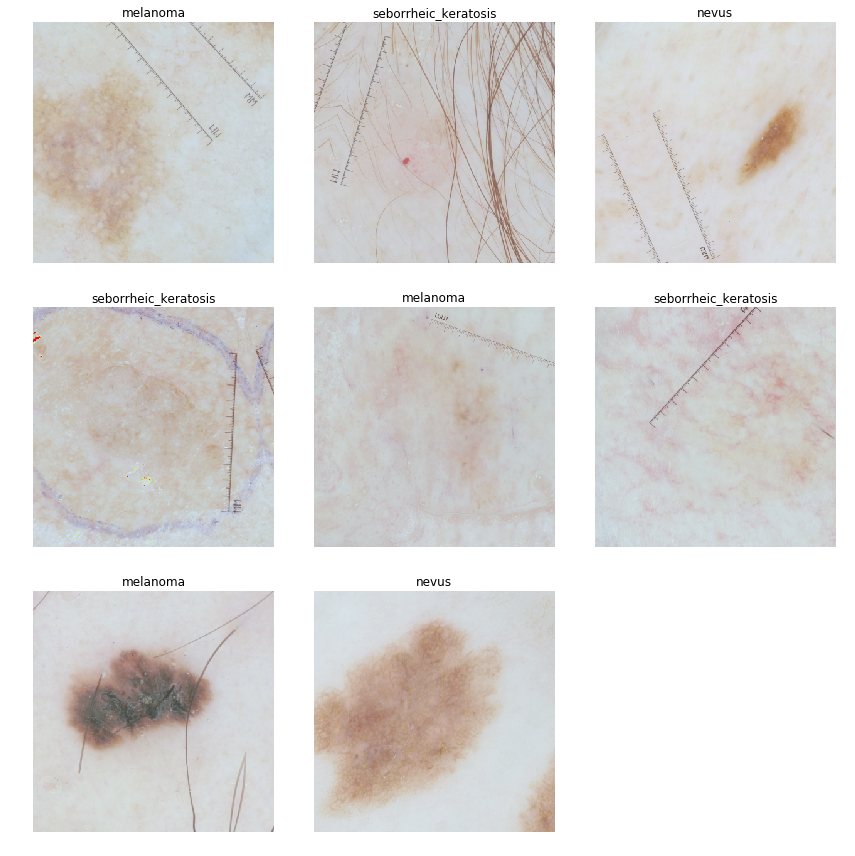

In [57]:
data = get_data(384, 8)
data.show_batch(rows=4)

See how transformation is applied to the same image

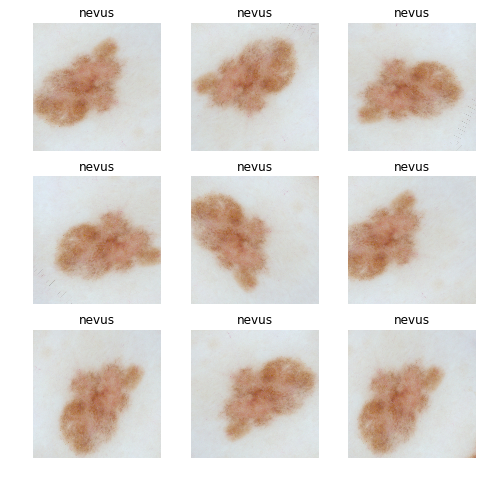

In [11]:
def _plot(i, j, ax):
    x,y = data.train_ds[300]
    x.show(ax, y=y)
    
plot_multi(_plot, 3, 3, figsize=(8,8))

Flush memory

In [12]:
gc.collect()

32821

Initialize model

In [13]:
learner = cnn_learner(data, 
                      models.resnet152, 
                      metrics=[accuracy], 
                      callback_fns=ShowGraph)

See model architecture

In [14]:
learner.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

Use the learning rate finder to find a maximum bound for cyclical learning rate

Use a factor of 10 or 20 less than the maximum bound for the minimum bound if only one cycle is used

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


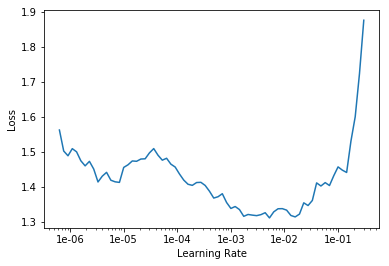

In [15]:
lr_find(learner)
learner.recorder.plot()

Begin training

epoch,train_loss,valid_loss,accuracy,time
0,1.040987,0.754034,0.700000,05:52
1,0.895021,0.812006,0.640000,05:52
2,0.805776,0.716263,0.666667,05:46
3,0.720836,0.664439,0.713333,05:42
4,0.711256,0.625512,0.713333,05:42
5,0.611937,0.610803,0.760000,05:51
6,0.584520,0.572590,0.773333,05:52
7,0.536177,0.573820,0.773333,05:44
8,0.468374,0.513518,0.780000,05:46
9,0.426122,0.535998,0.786667,05:42


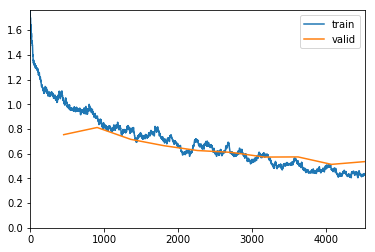

In [16]:
learner.fit_one_cycle(10, slice(1e-4, 1e-3), pct_start=0.6)

Save trained model so it can be used later

In [17]:
learner.save('model')

Interpret model classification on validation data

In [18]:
interp = ClassificationInterpretation.from_learner(learner)

Investigate the top losses

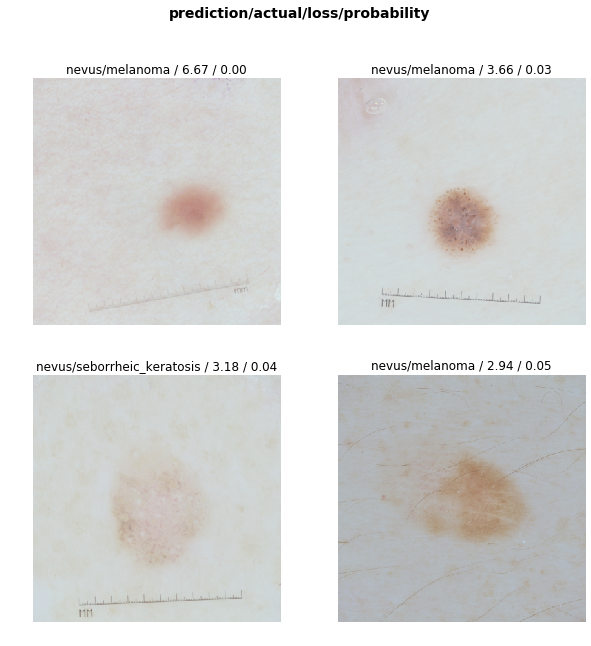

In [20]:
interp.plot_top_losses(4, figsize=(10,10), heatmap=False)

See how the model performs on the validation set

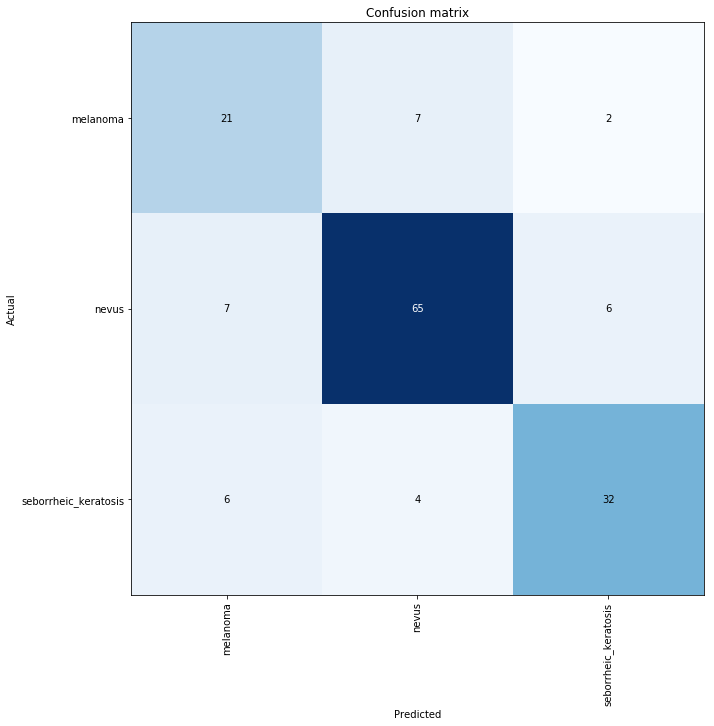

In [21]:
interp.plot_confusion_matrix(figsize=(10,10))

In [22]:
interp.most_confused()

[('melanoma', 'nevus', 7),
 ('nevus', 'melanoma', 7),
 ('nevus', 'seborrheic_keratosis', 6),
 ('seborrheic_keratosis', 'melanoma', 6),
 ('seborrheic_keratosis', 'nevus', 4),
 ('melanoma', 'seborrheic_keratosis', 2)]

Get predictions on the validation data

In [23]:
pred_probabilities, labels = learner.get_preds(ds_type=DatasetType.Valid)

# convert both torch arrays to numpy arrays
labels = labels.numpy()
preds = pred_probabilities.argmax(1).numpy()

See the index of each class

In [24]:
data.classes

['melanoma', 'nevus', 'seborrheic_keratosis']

Based on the class index, we can create functions that modify the model output to fit the two binary classification tasks:
1. melanoma vs. nevus and seborrheic keratosis
2. seborrheic keratosis vs. melanoma and nevus

In [25]:
task1_output_map = lambda x: 1 if x == 0 else 0
task2_output_map = lambda x: 1 if x == 2 else 0

Modify model output to fit both tasks

In [26]:
labels_task1 = list(map(task1_output_map, labels))
preds_task1 = list(map(task1_output_map, preds))

labels_task2 = list(map(task2_output_map, labels))
preds_task2 = list(map(task2_output_map, preds))

Create function to calculate ROC curve and Area under the ROC curve

In [29]:
def calculate_roc_curve_and_area(labels, preds):
    #  ROC curve
    fpr, tpr, _ = roc_curve(labels, preds, pos_label=1)
    
    #  ROC area
    area_under_curve = auc(fpr, tpr)
    
    return fpr, tpr, area_under_curve

Calculate ROC curve and Area under the ROC curve for both tasks

In [30]:
fpr_task1, tpr_task1, auc_task1 = calculate_roc_curve_and_area(labels_task1, preds_task1)
fpr_task2, tpr_task2, auc_task2 = calculate_roc_curve_and_area(labels_task2, preds_task2)

Plot the ROC curves for both binary classification tasks

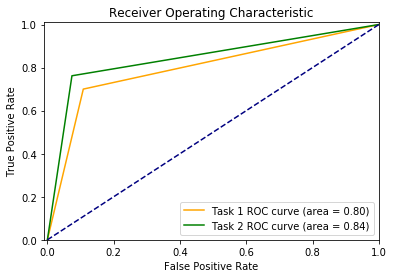

In [32]:
plt.figure()
plt.plot(fpr_task1, tpr_task1, color='orange', label='Task 1 ROC curve (area = %0.2f)' % auc_task1)
plt.plot(fpr_task2, tpr_task2, color='green', label='Task 2 ROC curve (area = %0.2f)' % auc_task2)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')

Export the trained model for inference

In [34]:
learner.export('trained_model.pkl')

Load the trained model for inference

In [58]:
learner = load_learner(data_path, 'trained_model.pkl')

Initialize test data path

In [82]:
test_data_path = data_path/'test'
test_data_path.ls()

[PosixPath('modified_data/test/nevus'),
 PosixPath('modified_data/test/melanoma'),
 PosixPath('modified_data/test/seborrheic_keratosis')]

Get predictions on the test data

In [94]:
test_label_map = {
    'melanoma': 0,
    'nevus': 1,
    'seborrheic_keratosis': 2
}
test_predictions = []
test_labels = []

for test_class_path in test_data_path.ls():
    test_label = test_label_map[str(test_class_path).split('/')[-1]]
    for test_image_path in test_class_path.ls():
        test_image = open_image(test_image_path)
        test_prediction = int(learner.predict(test_image)[1])
        test_predictions.append(test_prediction) 
        test_labels.append(test_label)

Modify model output to fit both tasks

In [95]:
labels_task1_test = list(map(task1_output_map, test_labels))
preds_task1_test = list(map(task1_output_map, test_predictions))

labels_task2_test = list(map(task2_output_map, test_labels))
preds_task2_test = list(map(task2_output_map, test_predictions))

Calculate ROC curve and Area under the ROC curve for both tasks

In [96]:
fpr_task1_test, tpr_task1_test, auc_task1_test = calculate_roc_curve_and_area(labels_task1_test, preds_task1_test)
fpr_task2_test, tpr_task2_test, auc_task2_test = calculate_roc_curve_and_area(labels_task2_test, preds_task2_test)

Plot the ROC curves for both binary classification tasks

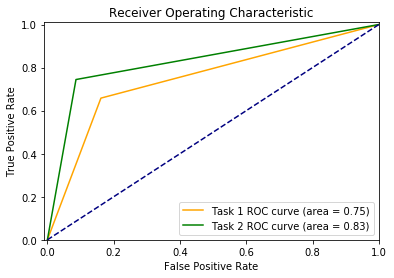

In [99]:
plt.figure()
plt.plot(fpr_task1_test, tpr_task1_test, color='orange', label='Task 1 ROC curve (area = %0.2f)' % auc_task1_test)
plt.plot(fpr_task2_test, tpr_task2_test, color='green', label='Task 2 ROC curve (area = %0.2f)' % auc_task2_test)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.01])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')